In [1]:
import datetime
from functools import lru_cache
from textwrap import dedent

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pystow
import seaborn as sns
import numpy as np
from indra.assemblers.english import EnglishAssembler
from indra.literature import pubmed_client
from indra.preassembler import Preassembler
from indra.sources import SOURCE_INFO
from indra.tools.assemble_corpus import run_preassembly
from IPython.display import Markdown, display
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tabulate import tabulate
from tqdm.auto import tqdm
from indra.statements import stmt_from_json
from collections import Counter, defaultdict
from statsmodels.stats.multitest import multipletests

import json
from indra_cogex.client import Neo4jClient, get_node_counter, get_stmts_for_stmt_hashes
from indra_cogex.info import env
from indra.databases.mesh_client import is_disease
from scipy.stats import binomtest, linregress

set_matplotlib_formats("svg")

In [2]:
env()

Key,Value
OS,posix
Platform,Darwin
Release,22.1.0
Time,Fri Jan 6 16:01:12 2023
Python,3.11.0
INDRA Version,1.22.0
INDRA Git Hash,fe603882718e919bd342247be92884c0876150fa
INDRA CoGEx Version,1.0.0
INDRA CoGEx Git Hash,c4d14f6b221adf5d79bb629323709992178afc49
INDRA CoGEx Branch,indra-db-summary


In [3]:
client = Neo4jClient()

INFO: [2023-01-06 16:01:12] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2023-01-06 16:01:12] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection


From https://en.wikipedia.org/wiki/Tumor_necrosis_factor:

> As an adipokine, TNF promotes insulin resistance, and is associated with obesity-induced type 2 diabetes.[7] As a cytokine, TNF is used by the immune system for cell signaling. If macrophages (certain white blood cells) detect an infection, they release TNF to alert other immune system cells as part of an inflammatory response.[7]
>
> TNF signaling occurs through two receptors: TNFR1 and TNFR2.[8][9] TNFR1 is constituitively expressed on most cell types, whereas TNFR2 is restricted primarily to endothelial, epithelial, and subsets of immune cells.[8][9] TNFR1 signaling tends to be pro-inflammatory and apoptotic, whereas TNFR2 signaling is anti-inflammatory and promotes cell proliferation.[8][9] Suppression of TNFR1 signaling has been important for treatment of autoimmune disease,[10] whereas TNFR2 signaling promotes wound healing.[9] 

Ideas:

1. Compare correspondence between results on apoptotic process ([go:0006915](https://bioregistry.io/go:0006915) and cell proliferation ([go:0008283](https://bioregistry.io/go:0008283))
2. Look at TNFR1 (hgnc:11916) and TNFR2 (hgnc:11917). Should easily be able to recover the following biases:    
   - activation of TNFR1 to apoptosis
   - inhibition of TNFR1 to autoimmune disease
   - activation ot TNFR2 to cell proliferation

In [4]:
%%time
targets_df = pd.DataFrame(
    client.query_tx(
        """\
        MATCH p=(:BioEntity {id: "hgnc:11892"})-[r:indra_rel]->(t:BioEntity)
        WHERE NOT t.id STARTS WITH "uniprot:" 
        RETURN t.id, t.name, sum(r.evidence_count) as count
        ORDER BY count DESC
        """
    ),
    columns=["curie", "name", "evidences"]
)
targets_df.head(15)

CPU times: user 177 ms, sys: 20.3 ms, total: 197 ms
Wall time: 18.9 s


,curie,name,evidences
0,go:0006915,apoptotic process,15266
1,fplx:NFkappaB,NFkappaB,14360
2,go:0006954,inflammatory response,4851
3,go:0008219,cell death,4704
4,hgnc:6018,IL6,3903
5,go:0008283,cell population proliferation,2795
6,hgnc:11916,TNFRSF1A,2647
7,fplx:JNK,JNK,2222
8,hgnc:6025,CXCL8,2075
9,hgnc:5344,ICAM1,2047


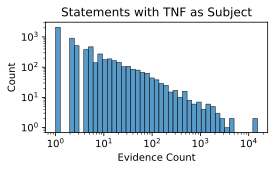

In [5]:
fix, ax = plt.subplots(figsize=(4, 2))
sns.histplot(targets_df["evidences"], log_scale=True, ax=ax)
ax.set_yscale("log")
ax.set_xlabel("Evidence Count")
ax.set_title("Statements with TNF as Subject")
plt.show()

# Query Relations to Apopotosis

In [13]:
%%time
res = client.query_tx(
    """\
    MATCH (:BioEntity {id: "hgnc:11892"})-[r:indra_rel]->(:BioEntity {id: 'go:0006915'})
    MATCH (:Evidence {stmt_hash: r.stmt_hash})-[:has_citation]->(p:Publication)-[:annotated_with]->(a:BioEntity)
    RETURN r.stmt_hash, r.evidence_count, r.stmt_json, collect({publication: p.id, annotation_curie: a.id, annotation_name: a.name})
    """
)

# parse INDRA statements
processed_res = [
    (stmt_hash, ev, stmt_from_json(json.loads(stmt_json)), annotations)
    for stmt_hash, ev, stmt_json, annotations in res
]

len(processed_res)

CPU times: user 2.29 s, sys: 191 ms, total: 2.49 s
Wall time: 27.7 s


34

Investigate the actual statments - there are various bound conditions and modifications that make there be multple statements, but these boil down to the same Activation or Inhibition statement.

In [15]:
sorted([stmt for _, _, stmt, _ in processed_res], key=str)

[Activation(TNF(), apoptotic process()),
 Activation(TNF(bound: [3H, True]), apoptotic process()),
 Activation(TNF(bound: [55-kDa type I TNFR, True]), apoptotic process()),
 Activation(TNF(bound: [75-kDa type II TNFR, True]), apoptotic process()),
 Activation(TNF(bound: [CASP3, True]), apoptotic process()),
 Activation(TNF(bound: [CD79A, True]), apoptotic process()),
 Activation(TNF(bound: [Death_receptor, True]), apoptotic process()),
 Activation(TNF(bound: [FASLG, True]), apoptotic process()),
 Activation(TNF(bound: [Infliximab, True]), apoptotic process()),
 Activation(TNF(bound: [TNF receptor, True]), apoptotic process()),
 Activation(TNF(bound: [TNF-R1 receptor, True]), apoptotic process()),
 Activation(TNF(bound: [TNF-alphaR, True]), apoptotic process()),
 Activation(TNF(bound: [TNF-receptor, True]), apoptotic process()),
 Activation(TNF(bound: [TNFRI receptor, True]), apoptotic process()),
 Activation(TNF(bound: [TNFRSF, True]), apoptotic process()),
 Activation(TNF(bound: [TNFR

In [22]:
evidence_counts = Counter()
for _, evidence_count, stmt, _ in processed_res:
    evidence_counts[stmt.__class__.__name__] += evidence_count
    
activation_ratio = evidence_counts["Activation"] / sum(evidence_counts.values())

evidence_counts, activation_ratio

(Counter({'Activation': 14015, 'Inhibition': 1246}), 0.9183539741825568)

In [8]:
activation_publications_set = set()
activation_annotations_set = set()
inhibition_publications_set = set()
inhibition_annotations_set = set()

for _, stmt, annotations in processed_res:
    if stmt.__class__.__name__ == "Activation":
        for annotation in annotations:
            activation_publications_set.add(annotation["publication"])
            activation_annotations_set.add(annotation["annotation_curie"])
    elif stmt.__class__.__name__ == "Inhibition":
        for annotation in annotations:
            inhibition_publications_set.add(annotation["publication"])
            inhibition_annotations_set.add(annotation["annotation_curie"])

publications_set = activation_publications_set | inhibition_publications_set
annotations_set = activation_annotations_set | inhibition_annotations_set

total_publications = len(publications_set)
activation_publications = len(activation_publications_set)
inhibition_publications = len(inhibition_publications_set)

both = len(activation_publications_set.intersection(inhibition_publications_set))

print(
    f"Of {total_publications:,} publications, {activation_publications:,}"
    f" ({activation_publications/total_publications:.1%}) correspond to activation and"
    f" {inhibition_publications:,} ({inhibition_publications/total_publications:.1%}) correspond to inhibition."
    f" {both:,} ({both/total_publications:.1%}) publications mention both activation and inhibition."
)

Of 8,006 publications, 7,499 (93.7%) correspond to activation and 913 (11.4%) correspond to inhibition. 406 (5.1%) publications mention both activation and inhibition.


In [9]:
dd = defaultdict(lambda: defaultdict(set))
for _, stmt, annotations in processed_res:
    for annotation in annotations:
        mesh_id = annotation["annotation_curie"].removeprefix("mesh:")
        if not is_disease(mesh_id):
            continue
        dd[stmt.__class__.__name__][mesh_id, annotation["annotation_name"]].add(annotation["publication"])

df = pd.DataFrame({
    stmt_class_name: {k: len(v) for k,v in ddd.items()} 
    for stmt_class_name, ddd in dd.items()
}).fillna(0).astype(int)

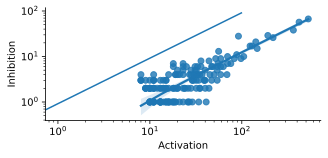

In [31]:
# This shows that there's some kind of text mining bias happening
g = sns.lmplot(data=df, x="Activation", y="Inhibition", height=2.3, aspect=2)
sns.lineplot(x=np.arange(100), y=np.arange(100) * activation_ratio, ax=g.ax)
g.set(xscale="log", yscale="log")
plt.show()

In [11]:
linregress(
    x=df["Activation"],
    y=df["Inhibition"],
)

LinregressResult(slope=0.12433551484889949, intercept=-0.05677372409128034, rvalue=0.9578853626969723, pvalue=0.0, stderr=0.0011357532040391144, intercept_stderr=0.03335061893109812)

In [12]:
# Filter for mesh annotations occurring in a minimum number of papers
df = df[df["Activation"]+ df["Inhibition"] > 10]

# Estimated ratio of activation to inhibitions based on the number of publications, assuming
#  they're equally distributed

# doesn't work well
# p = stmt_counter["Activation"] / (stmt_counter["Activation"] + stmt_counter["Inhibition"])

# this doesn't work at all
# p = activation_publications/total_publications

# guess and checked for this to make sure there was variety
p = 0.86

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binomtest.html
df["p"] = [
    binomtest(
        k=activation_count,
        n=activation_count + inhibition_count,
        p=p,
    ).pvalue
    for activation_count, inhibition_count in df[["Activation", "Inhibition"]].values
]
correction_results = multipletests(
    df["p"],
    method="fdr_bh",
    is_sorted=False,
    alpha=0.05,
)
df["q"] = correction_results[1]
df["mlq"] = -np.log10(df["q"]).round(2)
df.sort_values("q", inplace=True, ascending=True)

df["sign"] = np.sign(df["Activation"] - (df["Activation"] + df["Inhibition"]) * p)

print(f"Expected ratio between activation:inhibition: {p:.2}")

df.head(30)

Expected ratio between activation:inhibition: 0.86


,,Activation,Inhibition,p,q,mlq,sign
D009369,Neoplasms,364,38,0.007666,0.674613,0.17,1.0
D001172,"Arthritis, Rheumatoid",92,28,0.005412,0.674613,0.17,-1.0
D005909,Glioblastoma,44,2,0.056701,0.923910,0.03,1.0
D018805,Sepsis,47,3,0.149374,0.923910,0.03,1.0
D007680,Kidney Neoplasms,29,0,0.027249,0.923910,0.03,1.0
D009374,"Neoplasms, Experimental",27,0,0.025929,0.923910,0.03,1.0
D007249,Inflammation,529,67,0.051467,0.923910,0.03,1.0
D002292,"Carcinoma, Renal Cell",29,1,0.113437,0.923910,0.03,1.0
D015451,"Leukemia, Lymphocytic, Chronic, B-Cell",8,4,0.074970,0.923910,0.03,-1.0
D001930,Brain Injuries,18,0,0.162074,0.923910,0.03,1.0


# Next

later: look at different objects TNF activates differentiation vs. inflammatory response vs. apopotsis with different endpoints